# Ghalib Ammar Kazim
ID : 21031364

In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sklearn.cluster as cluster

In [25]:
def read_wb(filename):
    '''
    This functions returns two dataframes; one with country as a column and 2nd with years as columns
    '''
    df = pd.read_excel(filename,skiprows=3)
    labels = ['Country Code', 'Indicator Name','Indicator Code']
    y_df = df.set_index('Country Name').drop(labels=labels,axis=1)
    c_df = y_df.transpose()
    return (y_df, c_df)
elec1,elec2 = read_wb('API_EG.USE.ELEC.KH.PC_DS2_en_excel_v2_4029144.xls')
ren1,ren2 = read_wb('API_EG.ELC.RNEW.ZS_DS2_en_excel_v2_4036191.xls')
gas1, gas2 = read_wb('API_EN.ATM.GHGT.KT.CE_DS2_en_excel_v2_4026021.xls')

In [26]:
def normalization(v):
    '''
    normalizes the values in v
    '''
    return (v - v.min()) / (v.max() - v.min())
def remove_outlier(df_in):
    return  df_in[(np.abs(stats.zscore(df_in)) < 3).all(axis=1)]

In [27]:
def err_ranges(x, func, param, sigma):
    """
    Calculates the upper and lower limits for the function, parameters and
    sigmas for single value or array x. Functions values are calculated for 
    all combinations of +/- sigma and the minimum and maximum is determined.
    Can be used for all number of parameters and sigmas >=1.
    
    This routine can be used in assignment programs.
    """

    import itertools as iter
    
    # initiate arrays for lower and upper limits
    lower = func(x, *param)
    upper = lower
    
    uplow = []   # list to hold upper and lower limits for parameters
    for p,s in zip(param, sigma):
        pmin = p - s
        pmax = p + s
        uplow.append((pmin, pmax))
        
    pmix = list(iter.product(*uplow))
    
    for p in pmix:
        y = func(x, *p)
        lower = np.minimum(lower, y)
        upper = np.maximum(upper, y)
        
    return lower, upper   

In [28]:
def make_clusters(ser1,ser2,n_clusters=4,column_names=None):
    '''
    Plots clusters of the data.
    '''
    df = remove_outlier(pd.concat([ser1, ser2], axis=1,keys=column_names).dropna())
    km = cluster.KMeans(n_clusters=n_clusters)
    x_data = df[column_names[0]].values.reshape(-1, 1)
    y_data = df[column_names[1]].values
    km.fit(normalization(x_data),normalization(y_data))
    labels = km.labels_
    col = ["black","blue", "red", "green"]
    for l in range(n_clusters):
        plt.plot(x_data[labels==l], y_data[labels==l], "o", markersize=6, color=col[l])
    plt.xlabel(column_names[0])
    plt.ylabel(column_names[1])    
    plt.show()

We can observe that the graph shows clusters with respect to electric power consumption. First cluster cutoff is around 3000 and the second around 8000. The data suggests that countries with medium power consumption emit on average more greenhouse gases compared to countries with high and low consumption.

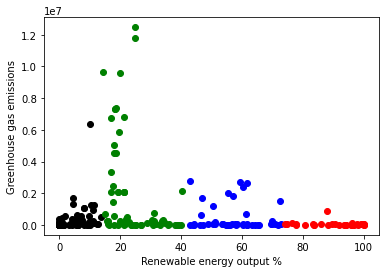

In [29]:
make_clusters(ren2.mean(), gas2.mean(),n_clusters=4,column_names=['Renewable energy output %', 'Greenhouse gas emissions'])

The graph as expectedly shows a negative correlation between greenhouse gases and renewable energy percentage. again the cutoff points are specific numbers such as 30% and 70%.

In [34]:
def quad(t,a, m,c):
    """Calculates exponential function with scale factor n0 and growth rate g."""
    
    return (t-a)**2 * m + c

def fit(func, x_values,y_values,p0=None,error=True,xlabel = None,ylabel=None):
    '''
    Fits the function to the data and predicts the next 10 years
    '''
    new_xvals = np.arange(x_values[0],x_values[-1]+10)
    popt, pcov = curve_fit(func, x_values, y_values,p0=p0,maxfev = 5000)
    sigma = np.sqrt(np.diag(pcov))
    y_pred = func(new_xvals,*popt)
    low, up = err_ranges(new_xvals, func, popt, sigma)
    plt.plot(new_xvals,y_pred)
    plt.plot(x_values,y_values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if error:
        plt.fill_between(new_xvals, low, up, color="Red", alpha=0.1)
    rms = np.sqrt(np.mean((y_values-func(x_values,*popt)))**2)    
    plt.show()
    return rms

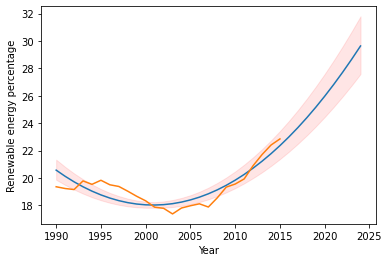

RMS Error : 2.377189043902315e-11


In [39]:
x_values = np.array([int(x) for x in  ren2['World'].dropna().index])
y_values = ren2['World'].dropna().values
err=fit(quad,x_values,y_values,xlabel="Year",ylabel="Renewable energy percentage")
print ("RMS Error :",err)

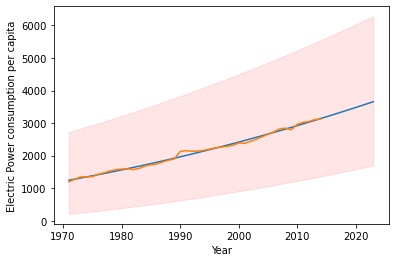

RMS Error : 8.11563567863645e-08


In [40]:
x_values = np.array([int(x) for x in  elec2['World'].dropna().index])
y_values = elec2['World'].dropna().values
err=fit(quad,x_values,y_values,xlabel="Year",ylabel="Electric Power consumption per capita")
print ("RMS Error :",err)